# Quantum control via superoscillations: Unitray evolution operator

In [1]:
using LinearAlgebra
using PyPlot
using DynamicPolynomials
using JuMP
using NLopt

In [2]:
# Pauli matrices
σx = [0 1
    1 0.]

σy = [0 -im
    im 0.]

σz = [1 0
    0 -1.];

## Target

In [3]:
# dimensionality of the system
N = 2

# The drift hamiltonian
H0_target = σz

# the control Hamiltonian
V_target = σx

# control field -- transform limited
ω₀ = 2.
E₀ = 10

# time
times = range(0, 2 * 2 * π / ω₀, 500)
Δt = times[2] - times[1]

E_target(t) = E₀ * sin(ω₀ * t)

E_target (generic function with 1 method)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


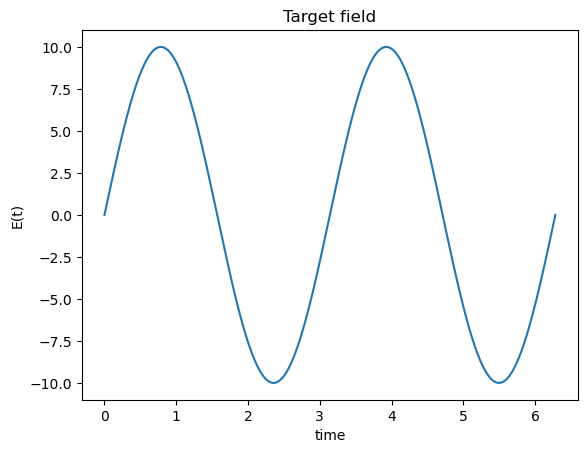

In [4]:
title("Target field")
plot(times, E_target.(times))
xlabel("time")
ylabel("E(t)")

show()

## Controlled system

In [5]:
# the control Hamiltonian
V_ctr = [0 0.9
        0.9 0.1]

# The drift hamiltonian  
H0_ctr = [1 0
        0 -2.]

# Controls field
function E_ctr(t, X)
    n = length(X)
    @assert n % 2 == 0
    
    k = n ÷ 2
    
    # Note using frequencies lower than ω₀, i.e., we want to get the superoscillating control
    Ω = (1:k) * (ω₀ / (2.  * k))
    
    # Using http://dlmf.nist.gov/4.21.E1_5 to parametrize the phase and amplitude
    return sum(
        a * cos(ω * t) + b * sin(ω * t) for (a, b, ω) in zip(X[1:k], X[(k + 1):end], Ω)
    ) 
end

E_ctr (generic function with 1 method)

## Utilities for working with Polynomials

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end
        
function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)#  LN_BOBYQA

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

## Generate the objective functions to find the controls
 
The idea is to find $E_{ctr}(t)$ such that

$$U_{ctr}(t + \Delta t, t) \to U_{target}(t + \Delta t, t), \quad \forall t.$$

Hence, we use the following cost function (objective function)

$$
   O = \sum_{k=0}^{N_t - 1} \Big\| U_{ctr}(\Delta t (k + 1), \Delta t k) - U_{target}(\Delta t (k + 1), \Delta t k) \Big\|_F^2 \to \min,
$$
where $\| A \|_F^2 = Tr(A A^{\dagger})$.

$$
    U_{ctr}(\Delta t (k + 1), \Delta t k) = T \exp\left[ -i \int_{\Delta t k}^{\Delta t (k + 1)} H_{ctr}(\tau)d\tau\right]
$$
$$
    = \exp\left[ -i \Delta t  H_{ctr}(k\Delta t  + \Delta t / 2)\right] + O(\Delta t^3).
$$

Recall
$$
    e^{-iG} = \frac{e^{-iG/2}}{e^{iG/2}} = \frac{1 - iG/2}{1 + iG/2} + O(G^3)
$$

If $G^\dagger = G$ then $\frac{1 - iG/2}{1 + iG/2}$ is unitary. This is known as the Cayley transform. Hence,

$$
    U_{ctr}(\Delta t (k + 1), \Delta t k) = \frac{1 - i(\Delta t / 2)  H_{ctr}(k\Delta t  + \Delta t / 2)}{1 + i(\Delta t/2)  H_{ctr}(k\Delta t  + \Delta t / 2)} + O(\Delta t^3).
$$
$$
   O' = \sum_{k=0}^{N_t - 1} \Big\| [1 - i(\Delta t / 2)  H_{ctr}(k\Delta t  + \Delta t / 2)] - U_{target}(\Delta t (k + 1), \Delta t k) [1 + i(\Delta t/2)  H_{ctr}(k\Delta t  + \Delta t / 2)] \Big\|_F^2 \to \min.
$$

Better way to see that
$$
    O = \sum_k \Big\| \exp\left[ -i \Delta t  H_{ctr}(k\Delta t  + \Delta t / 2)\right] - U_{target}(\Delta t (k + 1), \Delta t k) \Big\|_F^2 + O(\Delta t^3)
$$
$$
    = \sum_k \Big\| \Big(\exp\left[ -i \Delta t  H_{ctr}(k\Delta t  + \Delta t / 2)\right] - U_{target}(\Delta t (k + 1), \Delta t k) \Big) \exp\left[ i \Delta t / 2  H_{ctr}(k\Delta t  + \Delta t / 2)\right]  \Big\|_F^2 + O(\Delta t^3)
$$
$$
    = \sum_k \Big\| \exp\left[ -i \Delta t/2  H_{ctr}(k\Delta t  + \Delta t / 2)\right] - U_{target}(\Delta t (k + 1), \Delta t k) \exp\left[ i \Delta t / 2  H_{ctr}(k\Delta t  + \Delta t / 2)\right]  \Big\|_F^2 + O(\Delta t^3)
$$
$$
    = \sum_k \Big\| \left[ 1 -i \Delta t/2  H_{ctr}(k\Delta t  + \Delta t / 2)\right] - U_{target}(\Delta t (k + 1), \Delta t k) \left[ 1 + i \Delta t / 2  H_{ctr}(k\Delta t  + \Delta t / 2)\right]  \Big\|_F^2 + O(\Delta t^2)
$$




In [7]:
@polyvar X[1:10]

(PolyVar{true}[X₁, X₂, X₃, X₄, X₅, X₆, X₇, X₈, X₉, X₁₀],)

In [8]:
U_target(t) = exp(-im * Δt * Matrix(H0_target + E_target(t) * V_target))
    
H_ctr(t, X) = H0_ctr + V_ctr * E_ctr(t, X)

obj = sum(
    square_frobenius_norm(
        (I - im * (Δt / 2) * H_ctr(t + Δt / 2, X))  
        - U_target(t + Δt / 2) * (I + im * (Δt / 2) * H_ctr(t + Δt / 2, X))
    ) 
    for t in times[1:end - 1]
);

## Get the control field

In [9]:
found_X = local_minimize(obj, zeros(length(X)))

10-element Vector{Float64}:
 -101.4742429022984
 -110.6638425327249
    4.169158196378424
  195.12173482740465
    9.005804615123598
  181.49699910286253
   -2.4973065014577087
    0.6973767176293153
  305.3657787167191
 -224.15935673045647

In [10]:
obj(found_X)

0.5526021349585815

Let $U$ be unitary, then
$$
    \| U \|_F^2 = Tr(U U^\dagger) = Tr(1) = N.
$$

Let $U_{1,2}$ be unitaries, then
$$
\| U_1 - U_2 \|_F \leq \| U_1 \|_F + \| U_2 \|_F = 2 \sqrt{N}
$$

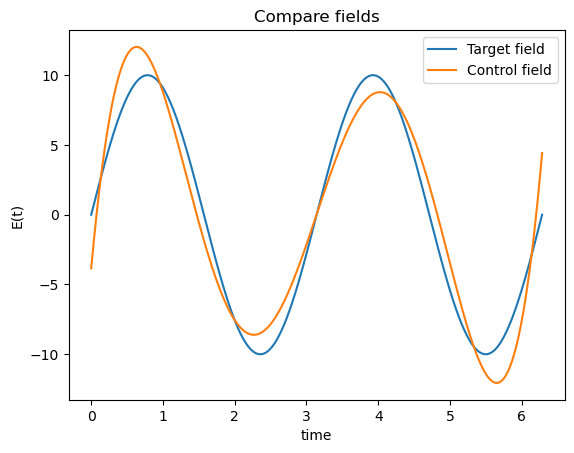

In [11]:
title("Compare fields")
plot(times, E_target.(times), label="Target field")
plot(times, [E_ctr(t, found_X) for t in times], label="Control field")
xlabel("time")
ylabel("E(t)")
legend()

show()

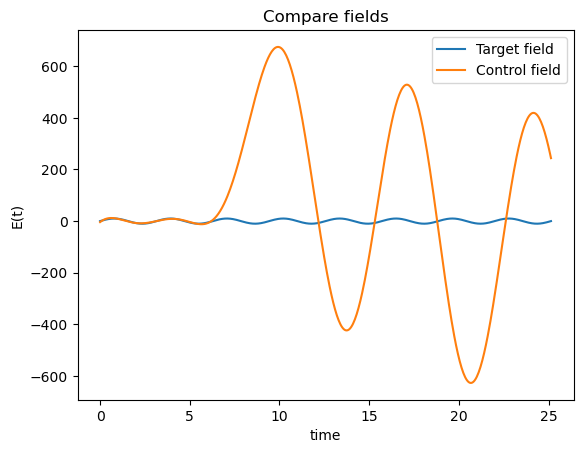

In [12]:
title("Compare fields")

longer_times = 4 * times

plot(longer_times, E_target.(longer_times), label="Target field")
plot(longer_times, [E_ctr(t, found_X) for t in longer_times], label="Control field")
xlabel("time")
ylabel("E(t)")
legend()

show()

## Comparing dynamics for a given initial state

In [13]:
ψ₀ = [1; 0]

Ψ_target = zeros(Complex, length(times), length(ψ₀))
Ψ_target[1, :] = ψ₀ 

for k in 2:length(times)
     Ψ_target[k, :] = U_target(Δt * (k - 2) + Δt / 2) * Ψ_target[k - 1, :]
end

#######################
U_ctr(t, X) = exp(-im * Δt * Matrix(H0_ctr + E_ctr(t, X) * V_ctr))
    
Ψ_ctr = zeros(Complex, length(times), length(ψ₀))
Ψ_ctr[1, :] = ψ₀ 

for k in 2:length(times)
     Ψ_ctr[k, :] = U_ctr(Δt * (k - 2) + Δt / 2, found_X) * Ψ_ctr[k - 1, :]
end

In [14]:
nz_target = real.([Ψ_target[k, :]' * σz * Ψ_target[k, :] for k in 1:length(times)])

nz_ctr = real.([Ψ_ctr[k, :]' * σz * Ψ_ctr[k, :] for k in 1:length(times)]);

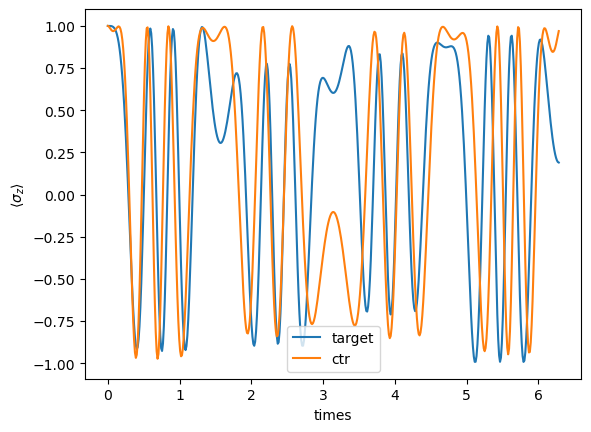

In [15]:
plot(times, nz_target, label="target")
plot(times, nz_ctr, label="ctr")
xlabel("times")
ylabel(L"\langle \sigma_z \rangle")
legend()
show()

## Preliminary conclusion

When tracking the unitary evolution operator, if the control Hamiltonians of control and target systems are similar (congruent?) then the control field tries to preproduce (up to a constant) the filed applied on the target system. In other words, it looks like a linear response.